In [39]:
import os
import json

def get_category_files(base_path, target_styles, data_type='image'):
    """
    특정 카테고리의 파일들을 수집하고 정렬하는 함수
    
    Args:
        base_path (str): 기본 경로
        target_styles (list): 처리할 카테고리 리스트
        data_type (str): 'image' 또는 'label' (기본값: 'image')
    
    Returns:
        dict: 카테고리별 정렬된 파일 경로 딕셔너리
    """
    category_files = {}
    
    for style in target_styles:
        style_path = os.path.join(base_path, style)
        if not os.path.isdir(style_path):
            print(f"경고: {style} 카테고리 폴더가 존재하지 않습니다.")
            continue
            
        if data_type == 'image':
            # 이미지 파일 수집 및 정렬
            files = [os.path.join(style_path, f) for f in os.listdir(style_path) 
                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            files.sort()  # 파일 경로 기준 정렬
        elif data_type == 'label':
            # JSON 파일 수집 및 정렬
            files = [os.path.join(style_path, f) for f in os.listdir(style_path) 
                    if f.lower().endswith('.json')]
            files.sort()  # 파일 경로 기준 정렬
        else:
            raise ValueError("data_type은 'image' 또는 'label'이어야 합니다.")
            
        category_files[style] = files
    
    # 결과 출력
    for style, files in category_files.items():
        print(f"\n{style} 스타일:")
        print(f"파일 개수: {len(files)}개")
        if files:
            if data_type == 'image':
                print("첫 번째 이미지:", os.path.basename(files[0]))
            else:
                try:
                    with open(files[0], 'r', encoding='utf-8') as f:
                        json_data = json.load(f)
                    print("첫 번째 JSON 파일:", os.path.basename(files[0]))
                    print("JSON 키:", list(json_data.keys()))
                except:
                    print("JSON 파일 읽기 실패:", os.path.basename(files[0]))
    
    return category_files

# 사용 예시
base_path = "./k_fashsion/원천데이터/원천데이터_1"
target_styles = ['레트로', '로멘틱']

# 이미지 파일 수집
image_files = get_category_files(base_path, target_styles, data_type='image')

# 라벨 파일 수집
label_path = "./k_fashsion/라벨링데이터/"
label_files = get_category_files(label_path, target_styles, data_type='label')

경고: 로멘틱 카테고리 폴더가 존재하지 않습니다.

레트로 스타일:
파일 개수: 200개
첫 번째 이미지: 1016530.jpg
경고: 로멘틱 카테고리 폴더가 존재하지 않습니다.

레트로 스타일:
파일 개수: 200개
첫 번째 JSON 파일: 1016530.json
JSON 키: ['이미지 정보', '데이터셋 정보']


In [34]:
image_files

{'레트로': ['./k_fashsion/원천데이터/원천데이터_1/레트로/1081420.jpg',
  './k_fashsion/원천데이터/원천데이터_1/레트로/137932.jpg',
  './k_fashsion/원천데이터/원천데이터_1/레트로/404114.jpg',
  './k_fashsion/원천데이터/원천데이터_1/레트로/715248.jpg',
  './k_fashsion/원천데이터/원천데이터_1/레트로/611006.jpg',
  './k_fashsion/원천데이터/원천데이터_1/레트로/1124275.jpg',
  './k_fashsion/원천데이터/원천데이터_1/레트로/345111.jpg',
  './k_fashsion/원천데이터/원천데이터_1/레트로/96540.jpg',
  './k_fashsion/원천데이터/원천데이터_1/레트로/448915.jpg',
  './k_fashsion/원천데이터/원천데이터_1/레트로/450828.jpg',
  './k_fashsion/원천데이터/원천데이터_1/레트로/282739.jpg',
  './k_fashsion/원천데이터/원천데이터_1/레트로/68476.jpg',
  './k_fashsion/원천데이터/원천데이터_1/레트로/618143.jpg',
  './k_fashsion/원천데이터/원천데이터_1/레트로/1162989.jpg',
  './k_fashsion/원천데이터/원천데이터_1/레트로/506064.jpg',
  './k_fashsion/원천데이터/원천데이터_1/레트로/11994.jpg',
  './k_fashsion/원천데이터/원천데이터_1/레트로/1162021.jpg',
  './k_fashsion/원천데이터/원천데이터_1/레트로/996201.jpg',
  './k_fashsion/원천데이터/원천데이터_1/레트로/619459.jpg',
  './k_fashsion/원천데이터/원천데이터_1/레트로/486302.jpg',
  './k_fashsion/원천데이터/원천데이터_1/레트로/527651.jpg',
  './

In [38]:
label_files

{'레트로': ['./k_fashsion/라벨링데이터/레트로/694509.json',
  './k_fashsion/라벨링데이터/레트로/224668.json',
  './k_fashsion/라벨링데이터/레트로/284.json',
  './k_fashsion/라벨링데이터/레트로/338.json',
  './k_fashsion/라벨링데이터/레트로/611077.json',
  './k_fashsion/라벨링데이터/레트로/527956.json',
  './k_fashsion/라벨링데이터/레트로/198612.json',
  './k_fashsion/라벨링데이터/레트로/314.json',
  './k_fashsion/라벨링데이터/레트로/456258.json',
  './k_fashsion/라벨링데이터/레트로/620643.json',
  './k_fashsion/라벨링데이터/레트로/1163961.json',
  './k_fashsion/라벨링데이터/레트로/312951.json',
  './k_fashsion/라벨링데이터/레트로/1710.json',
  './k_fashsion/라벨링데이터/레트로/356906.json',
  './k_fashsion/라벨링데이터/레트로/477499.json',
  './k_fashsion/라벨링데이터/레트로/345111.json',
  './k_fashsion/라벨링데이터/레트로/478404.json',
  './k_fashsion/라벨링데이터/레트로/715248.json',
  './k_fashsion/라벨링데이터/레트로/610778.json',
  './k_fashsion/라벨링데이터/레트로/486232.json',
  './k_fashsion/라벨링데이터/레트로/385049.json',
  './k_fashsion/라벨링데이터/레트로/323703.json',
  './k_fashsion/라벨링데이터/레트로/1116.json',
  './k_fashsion/라벨링데이터/레트로/412370.json',
  './k_fashsion/라벨링데이

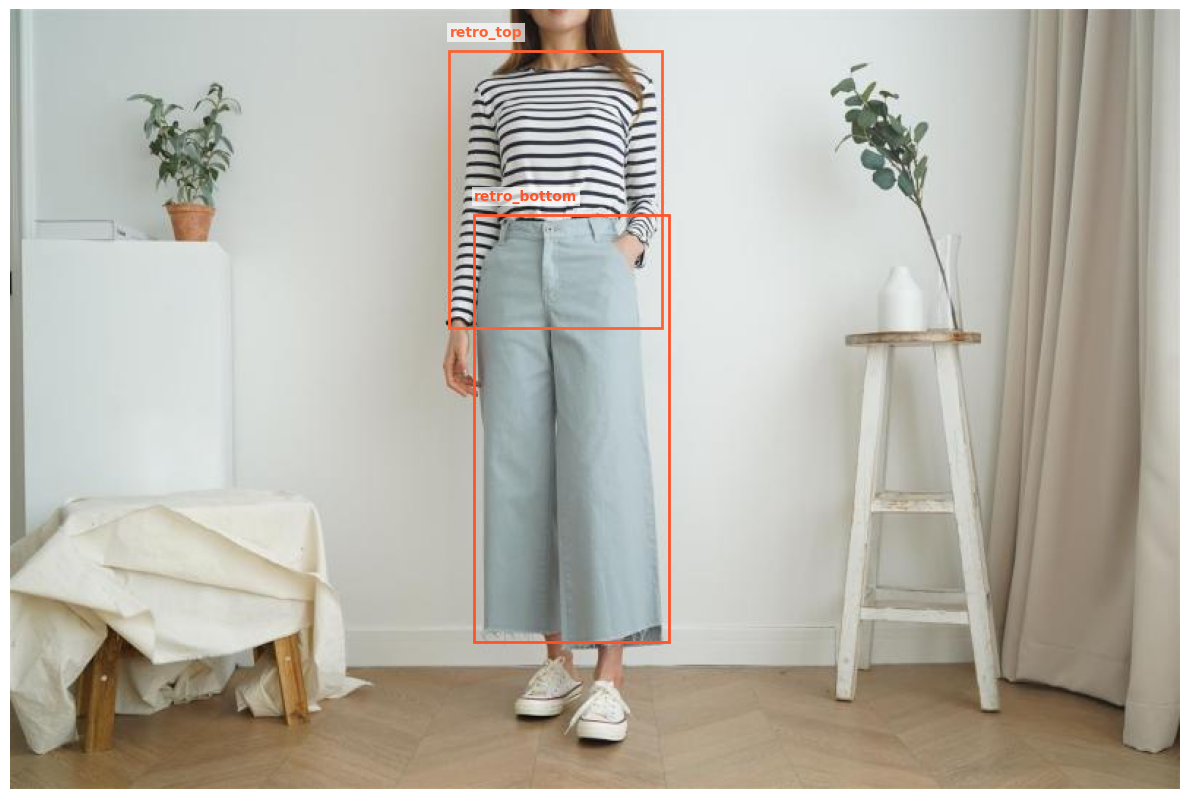


파일명 변환 매핑:
원본: 1016530 -> 변환: retro_001
원본: 1016553 -> 변환: retro_002
원본: 1016618 -> 변환: retro_003
원본: 1028690 -> 변환: retro_004
원본: 1029079 -> 변환: retro_005


In [ ]:
import os
import json
import shutil
import numpy as np
from PIL import Image, ImageDraw
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

def create_dataset_structure():
    """데이터셋 폴더 구조 생성"""
    dirs = [
        "dataset/images/train", "dataset/images/val",
        "dataset/labels/train", "dataset/labels/val",
        "dataset/masks/train", "dataset/masks/val"
    ]
    for d in dirs:
        os.makedirs(d, exist_ok=True)

def create_label_mapping():
    """통합 라벨 매핑 생성"""
    # 기본 카테고리
    clothing_categories = {
        "아우터": "outer",
        "상의": "top",
        "하의": "bottom",
        "원피스": "dress"
    }
    
    # 스타일 카테고리
    style_categories = {
        "트래디셔널": "traditional", "매니시": "mannish", 
        "페미닌": "feminine", "에스닉": "ethnic",
        "컨템포러리": "contemporary", "내추럴": "natural",
        "스포티": "sporty", "캐주얼": "casual",
        "클래식": "classic", "모던": "modern",
        "레트로": "retro", "로맨틱": "romantic"
    }
    
    # 통합 라벨 생성
    label_mapping = {}
    label_list = []
    label_id = 0
    
    for style_kr, style_eng in style_categories.items():
        for cloth_kr, cloth_eng in clothing_categories.items():
            label = f"{style_eng}_{cloth_eng}"
            label_kr = f"{style_kr}_{cloth_kr}"
            label_mapping[label_kr] = label_id
            label_list.append(label)
            label_id += 1
    
    return label_mapping, label_list, clothing_categories, style_categories

def convert_to_yolo_format(rect_coords, img_width, img_height):
    """렉트 좌표를 YOLO 포맷으로 변환"""
    x = rect_coords["X좌표"]
    y = rect_coords["Y좌표"]
    w = rect_coords["가로"]
    h = rect_coords["세로"]
    
    x_center = (x + w/2) / img_width
    y_center = (y + h/2) / img_height
    width = w / img_width
    height = h / img_height
    
    return [x_center, y_center, width, height]

def create_mask_from_polygon(polygon_coords, img_width, img_height):
    """폴리곤 좌표로부터 마스크 생성"""
    mask = Image.new('L', (img_width, img_height), 0)
    draw = ImageDraw.Draw(mask)
    
    points = []
    sorted_coords = sorted([(k, v) for k, v in polygon_coords.items()], 
                         key=lambda x: int(''.join(filter(str.isdigit, x[0]))))
    
    for i in range(len(sorted_coords)//2):
        x = sorted_coords[i][1]
        y = sorted_coords[i + len(sorted_coords)//2][1]
        points.append((x, y))
    
    draw.polygon(points, fill=255)
    return mask

def process_files(image_files, label_files, split='train'):
    """전체 파일 처리"""
    create_dataset_structure()
    label_mapping, label_list, clothing_categories, style_categories = create_label_mapping()
    
    processed_files = []
    filename_mapping = {}
    style_counters = {}
    
    for style, img_paths in image_files.items():
        style_counters[style] = 1
        
        for img_path in img_paths:
            orig_basename = Path(img_path).stem
            new_basename = f"{style_categories.get(style, 'unknown')}_{style_counters[style]:03d}"
            filename_mapping[orig_basename] = new_basename
            style_counters[style] += 1
            
            # 이미지 복사
            new_img_path = f"dataset/images/{split}/{new_basename}.jpg"
            shutil.copy2(img_path, new_img_path)
            
            # 라벨 처리
            label_path = next((p for p in label_files.get(style, []) 
                             if orig_basename in p), None)
            
            if label_path:
                with open(label_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                
                img_info = data["이미지 정보"]
                img_width = img_info["이미지 너비"]
                img_height = img_info["이미지 높이"]
                
                labels = []
                rect_coords = data["데이터셋 정보"]["데이터셋 상세설명"]["렉트좌표"]
                style_info = data["데이터셋 정보"]["데이터셋 상세설명"]["라벨링"]["스타일"][0]["스타일"]
                
                for cloth_kr, cloth_eng in clothing_categories.items():
                    coords = rect_coords.get(cloth_kr, [{}])[0]
                    if coords:
                        yolo_coords = convert_to_yolo_format(coords, img_width, img_height)
                        label_key = f"{style_info}_{cloth_kr}"
                        if label_key in label_mapping:
                            label_id = label_mapping[label_key]
                            labels.append([label_id] + yolo_coords)
                
                # 라벨 저장
                if labels:
                    new_label_path = f"dataset/labels/{split}/{new_basename}.txt"
                    with open(new_label_path, 'w') as f:
                        for label in labels:
                            f.write(' '.join(map(str, label)) + '\n')
                
                # 마스크 생성
                polygon_coords = data["데이터셋 정보"]["데이터셋 상세설명"]["폴리곤좌표"]
                for category, coords in polygon_coords.items():
                    if coords and coords[0]:
                        mask = create_mask_from_polygon(coords[0], img_width, img_height)
                        mask_path = f"dataset/masks/{split}/{new_basename}_{category}.png"
                        mask.save(mask_path)
                
                processed_files.append((new_basename, labels))
    
    return processed_files, filename_mapping, label_list

def visualize_bbox(img_path, label_path, label_list):
    """바운딩 박스 시각화"""
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width = img.shape[:2]
    
    plt.figure(figsize=(12, 12))
    plt.imshow(img)
    
    # 색상 설정
    colors = plt.cm.rainbow(np.linspace(0, 1, len(label_list)))
    
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    for line in lines:
        category_id, x_center, y_center, w, h = map(float, line.strip().split())
        
        # 절대좌표 변환
        abs_x = int(x_center * width)
        abs_y = int(y_center * height)
        abs_w = int(w * width)
        abs_h = int(h * height)
        x1 = abs_x - abs_w//2
        y1 = abs_y - abs_h//2
        
        # 박스 및 레이블 그리기
        color = colors[int(category_id)]
        rect = plt.Rectangle((x1, y1), abs_w, abs_h,
                           fill=False,
                           color=color,
                           linewidth=2)
        plt.gca().add_patch(rect)
        
        label = label_list[int(category_id)] if int(category_id) < len(label_list) else f"Class {int(category_id)}"
        plt.text(x1, y1-10, label,
                color=color,
                fontsize=10,
                fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2))
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# 실행
processed_files, filename_mapping, label_list = process_files(image_files, label_files)

# 결과 확인
if processed_files:
    first_file = processed_files[0]
    img_path = f"dataset/images/train/{first_file[0]}.jpg"
    label_path = f"dataset/labels/train/{first_file[0]}.txt"
    visualize_bbox(img_path, label_path, label_list)
    
    # 파일명 매핑 확인
    print("\n파일명 변환 매핑:")
    for orig, new in list(filename_mapping.items())[:5]:
        print(f"원본: {orig} -> 변환: {new}")